# S-Feature Analysis
This is an optional notebook where we will go through the steps of creating random walks using the S-path method. These can be used as a feature when learning HAS-embeddings in the HAS_entity_embeddings notebook. We will consider different implementation decisions and look at the results of using this feature for learning embeddings.

*What is this feature?* --> These random walks are intended to detect structural similarity. I.e. entities with similar types of neighbors are similar.

## Pre-requisite steps to run this notebook
1. You need to run the 1_candidate_label_creation notebook before this notebook.
2. gensim is a dependency. You can install it with `pip install --upgrade gensim`, or if you want to use Anaconda, `conda install -c conda-forge gensim`

In [1]:
import os
import random
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns

## parameters

**Embedding model parameters**   
*type_to_profile*: Q-node denoting the type of entities you want to create embeddings for (potentially do this for all types in the dataset and get rid of this parameter)  
*k*: Number of closest neighbors to consider hopping to when at some step of a random walk (~average degree in the original KG is recommended)  
*num_walks*: Number of random walks to start at each node with the S-feature walk method   
*walk_length*: Length of random walk started at each node  
*representation_size*: Number of latent dimensions to learn from each node  
*window_size*: Window size of skipgram model  
*workers*: Number of parallel processes  

**File/Directory parameters**  
*item_file*: File path for the file that contains entity to entity relationships (e.g. wikibase-item).  
*label_file*: File path for the file that contains wikidata labels.  
*work_dir*: same work_dir that you specified in the label creation notebook. We'll look for files created by that notebook here. Files created by this notebook will also be saved here.  
*store_dir*: Path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

In [7]:
# Embedding model params
type_to_profile = "Q44"
k = 2
num_walks = 10
walk_length = 10
representation_size = 64
window_size = 5
workers = 32

# File/Directory params
item_file = "../../Q44/data/Q44.part.wikibase-item.tsv"
label_file = "../../Q44/data/Q44.label.en.tsv"
work_dir = "../../Q44/profiler_work"
store_dir = "../../Q44"

# label_file = "../../Q154/data/parts/labels.en.tsv.gz"
# work_dir = "../../Q154/profiler_work"
# store_dir = "../../Q154"

### Process parameters and set up variables / file names

In [8]:
# Ensure paths are absolute
item_file = os.path.abspath(item_file)
label_file = os.path.abspath(label_file)
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
    
# Create directories
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
output_dir = "{}/S_walks_analysis".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Setting up environment variables 
os.environ["TYPE"] = type_to_profile
os.environ['ITEM_FILE'] = item_file
os.environ['LABEL_FILE'] = label_file
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['LABEL_CREATION'] = "{}/label_creation".format(work_dir)
os.environ['OUT'] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

### 1. Create simple embeddings for entities based on the types of their neighbors

These embeddings will have $|\tau|$ dimensions where $\tau$ is the set of distinct types amongst entities that share an edge with entities of type $t$. Each dimension of the embeddings will correspond to a type. The embedding for an entity will be created by filling in counts of neighbors of each type and normalizing each dimension.

#### 1.1 Gather list of entities of the type_to_profile along with the types of their neighbors and the counts of neighbors of those types

In [9]:
!kgtk query -i $ITEM_FILE -i $LABEL_CREATION/type_mapping.tsv --graph-cache $STORE \
-o $OUT/${TYPE}_entity_neighbor_types.tsv \
--match '`'"$ITEM_FILE"'`: (e1)-[]->(e2), type: (e1)-[]->(t1:`'"$TYPE"'`), type: (e2)-[]->(t2)' \
--return 'distinct e1 as entity, t2 as neighbor_type, count(e2) as count' \
--order-by 'e1, t2'

In [10]:
!head $OUT/${TYPE}_entity_neighbor_types.tsv | column -t -s $'\t'

entity     neighbor_type  count
Q12877510  Q12047392      1
Q12877510  Q131413        2
Q12877510  Q1349648       1
Q12877510  Q147538        1
Q12877510  Q15075508      12
Q12877510  Q152024        2
Q12877510  Q154           10
Q12877510  Q1549591       2
Q12877510  Q167270        14


#### 1.2 Load <entity, attribute, value> triples to Python, create embeddings from there. 

In [11]:
types_df = pd.read_csv("{}/{}_entity_neighbor_types.tsv".format(output_dir, type_to_profile), delimiter = '\t').fillna("")

neigh_types = types_df.neighbor_type.unique()
entities = types_df.entity.unique()
type_to_idx = {neigh_types[ix] : ix for ix in range(len(neigh_types))}
ent_to_idx = {entities[ix] : ix for ix in range(len(entities))}
embeddings = np.zeros((len(entities),len(neigh_types)))

for ent, neigh_type, count in zip(types_df['entity'], types_df['neighbor_type'], types_df['count']):
    embeddings[ent_to_idx[ent], type_to_idx[neigh_type]] = count

# normalize each dimension
embeddings -= np.min(embeddings,0)
embeddings /= [m if m != 0 else 1 for m in np.max(embeddings,0)]

### 2. Find the neighbors for each entity that are similar enough to hop to during a random walk.

**notes**  
some code here might be able to be optimized. Authors' code first sorts values in each dimension and binary searches for neighbors in range... this would also require choosing a value for $r$ - a parameter that controls size of the hypercube defining neighbors that are close enough to jump to next. Paper mentions you could adjust $r$ to aim for having number of neighbors in hypercube = average degree in original KG... This does not seem like it would be trivial to automate, and I am thinking we want to automate this. For now, just using simpler pythonic code and finding fixed number of closest neighbors.

From looking at their code, it appears as if they don't do any adjusting of $r$... I think they just choose $r = 1 / \#entities$. We could try this out to see how this works out. However for now, still just using a fixed number of closest neighbors approach.

Also, if we want to change how we deal with missing attribute values to only compare dimensions that both entities being compared have, we'd need to change that here.

In [12]:
# Get the closest k neighbors for each entity, where "closeness"
# is measured by maximum absolute difference in any dimension.
# This can be thought of as finding the smallest hypercube that is
# centered on an entity and contains k other entities within it.
# Params:
#     entities   - array of entities
#     embeddings - array where each row corresponds to the entity at the same index in the entities array,
#                  and each column is a numeric value corresponding to one dimension of the embeddings
#     k          - number of closest neighbors to find 
# Returns: a dictionary of {entity : array of neighbors}
def get_k_neighs(entities, embeddings, k):
    # NOTE - using a fixed number of closest neighbors. This approach may involve more computation,
    # so will need to keep this in mind when scaling up.
    entity_to_neighs = {}

    for i in range(len(entities)):
        max_diffs = np.max(np.abs(embeddings - embeddings[i]), 1)
        max_diffs[i] = np.inf # avoid including entity in its own list of neighbors
        entity_to_neighs[entities[i]] = entities[np.argpartition(max_diffs, k - 1)[:k]]
        
    return entity_to_neighs

In [13]:
entity_to_neighs = get_k_neighs(entities, embeddings, k)
display(entity_to_neighs)

{'Q12877510': array(['Q61976614', 'Q93552342'], dtype=object),
 'Q61976614': array(['Q12877510', 'Q93552342'], dtype=object),
 'Q93552342': array(['Q93560567', 'Q61976614'], dtype=object),
 'Q93557205': array(['Q93558270', 'Q61976614'], dtype=object),
 'Q93558270': array(['Q93557205', 'Q61976614'], dtype=object),
 'Q93559285': array(['Q12877510', 'Q61976614'], dtype=object),
 'Q93560567': array(['Q93552342', 'Q61976614'], dtype=object),
 'Q97412285': array(['Q12877510', 'Q61976614'], dtype=object)}

### 3. Perform the random walks

In [14]:
# Performs num_walks random walks at each node in the graph
# i.e. if there are 10 nodes in the gaph and num_walks=10, then we'll do 10*10 = 100 random walks.
# Returns a list of walks
def perform_walks(entity_to_neighs, walk_length=10, num_walks=10):
    start_ents = np.repeat(list(entity_to_neighs.keys()), num_walks)
    # pre-allocate walks array with initial values of ""
    walks = np.full((len(start_ents),walk_length), "", dtype='<U9')
    
    walks[:,0] = start_ents
    cur_length = 1
    while cur_length < walk_length:
        cur_ents = walks[:,cur_length - 1]
        # if we've previously hit a dead end, then we could have "" as a 
        # current entity value. In this case, we want to continue filling in "".
        neighbors = [np.array([""]) if e == "" else entity_to_neighs[e] for e in cur_ents]
        # if there are no neighbors for some entity 
        # we'll make the next entity we visit = ""
        neighbors = [np.array([-1]) if len(arr) < 1 else arr for arr in neighbors]
        next_ents = [np.random.choice(arr) for arr in neighbors]
        walks[:,cur_length] = next_ents
        cur_length += 1
    # trim ""s from any walks that reached a dead end
    walks = [list(arr[arr != ""]) for arr in walks]
    return walks

In [15]:
walks = perform_walks(entity_to_neighs, walk_length, num_walks)

### 4. Let's see what embeddings we learn if we only use this feature
Use Skip-Gram model to learn representations for the entities

In [16]:
%%time
model = Word2Vec(walks, size=representation_size, window=window_size, min_count=0, sg=1, hs=1,
                 workers=workers)
model.wv.save("{}/entity_embeddings.kv".format(output_dir))

CPU times: user 35.7 ms, sys: 15.7 ms, total: 51.4 ms
Wall time: 46.2 ms


We want similar entities to have more similar embeddings. This feature aims to capture a measure of structural similarity amongst entities of the same type. Therefore we will compare entities within a type to evaluate the embeddings that are learned with this feature.

The below doesn't work because we didn't acount for an entity not having ANY numeric attributes... should account for this. Although if we don't, not clear makes a big difference to final embeddings as long as we use other features as well.

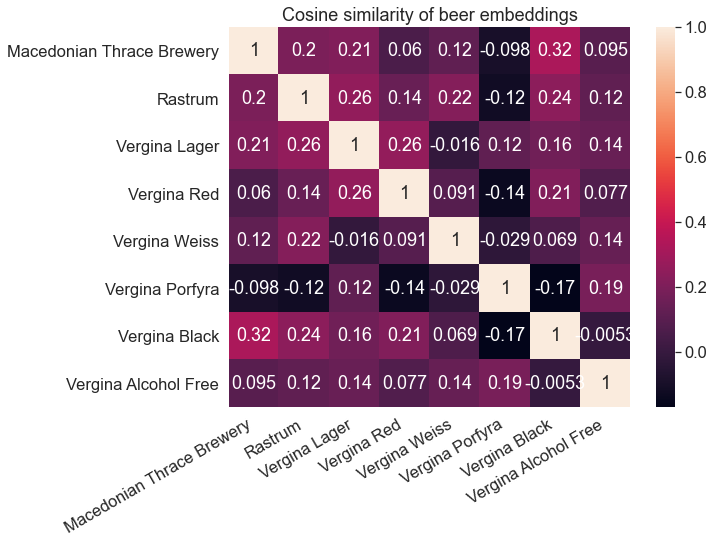

In [18]:
beer_vecs = model.wv['Q12877510', 'Q61976614', 'Q93552342', 'Q93557205', 'Q93559285', 'Q93558270', 'Q93560567', 'Q97412285']
similarity_mat = [model.wv.cosine_similarities(beer, beer_vecs) for beer in beer_vecs]
mask = np.zeros_like(similarity_mat)
mask[np.triu_indices_from(mask)] = True
labels = ['Macedonian Thrace Brewery', 'Rastrum', 'Vergina Lager', 'Vergina Red', 'Vergina Weiss', 'Vergina Porfyra', 'Vergina Black', 'Vergina Alcohol Free']
# Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
fig, ax = plt.subplots(figsize=(9,7))
sns.set(font_scale=1.5)
sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Cosine similarity of beer embeddings")
plt.show()